# Meshes

This example demonstrates the use of meshes in Continuity.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from continuity.data import Gmsh, OperatorDataset
from continuity.operators import DeepONet
from continuity.pde import div, grad, PhysicsInformedLoss

In [3]:
torch.manual_seed(0)
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)
plt.rcParams["legend.framealpha"] = 0.0


We use the `Gmsh` class to read a mesh from a file generated by Gmsh.

Info    : Reading '../data/meshes/mediterranean.msh'...
Info    : 9255 entities
Info    : 14386 nodes
Info    : 25871 elements
Info    : Done reading '../data/meshes/mediterranean.msh'


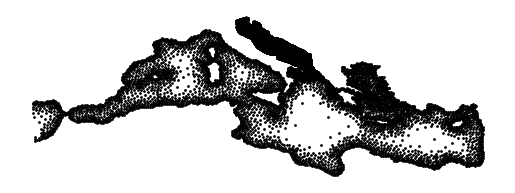

In [4]:
mesh = Gmsh("../data/meshes/mediterranean.msh")
vertices = mesh.get_vertices()

# We use longitude and latitude only and scale them to be in the range [-1, 1]
vertices = vertices[:, 1:]
vertices -= vertices.mean(0)
vertices /= vertices.abs().max()

# Plot
plt.scatter(vertices[:, 0], vertices[:, 1], 1, c="black")
plt.gca().axis("off")
plt.gca().set_aspect("equal")

## Problem Statement

Let's assume we have a set of temperature measurements and want to 
reconstruct a physically meaningful temperature distribution in the
whole mediterranean sea. We define a data set by generating random sensor inputs.

In [5]:
# Generate dataset
num_observation = 1
num_sensors = 5

x = torch.zeros(num_observation, num_sensors, 2)
u = torch.zeros(num_observation, num_sensors, 1)
y = torch.zeros(num_observation, num_sensors, 2)
v = torch.zeros(num_observation, num_sensors, 1)

for i in range(num_observation):

    # Select random sensor positions
    idx = torch.randperm(vertices.shape[0])[:num_sensors]
    x[i] = vertices[idx]

    # Generate random sensor measurements
    u[i] = torch.rand(num_sensors, 1)
    
    # The mapped function equals u the sensors
    # (but we will add a physics-informed loss later w.r.t to all vertices)
    y[i] = x[i]
    v[i] = u[i]

dataset = OperatorDataset(x, u, y, v)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

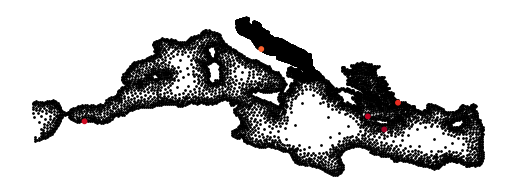

In [6]:
# Get a first observation from training set
u0 = torch.rand(num_sensors, 1)
x0, u0, _, _ = dataset[0]

# Plot
plt.scatter(vertices[:, 0], vertices[:, 1], 1, c="black")
plt.scatter(x0[:, 0], x0[:, 1], 10, u0, cmap="YlOrRd", vmin=-1, vmax=1)
plt.gca().axis("off")
plt.gca().set_aspect("equal")

## Neural Operator

In this example, we use a DeepONet architecture.

In [7]:
# Define operator
operator = DeepONet(dataset.shapes)

## Physics-informed loss

As we want to learn a physically meaningful completion, so we define a
physics-informed loss function satisfying: $$- \Delta v = 0$$

In [8]:
y_physics = vertices.clone().requires_grad_(True)[::10] # Use a subset of vertices for the physics-informed loss
mse = torch.nn.MSELoss()

def pde(x, u, y, v):
    # Sensor measurements
    loss = mse(v, u)

    # Physics-informed loss w.r.t. all vertices
    w = lambda y: operator(x, u, y)
    Delta = div(grad(w))

    y_all = y_physics.repeat(u.shape[0], 1, 1)
    loss += (Delta(y_all)**2).mean()

    return loss

loss_fn = PhysicsInformedLoss(pde)

## Training

We train the neural operator using the physics-informed loss function. 

In [9]:
optimizer = torch.optim.Adam(operator.parameters(), lr=1e-3)

operator.compile(optimizer, loss_fn)
operator.fit(data_loader, epochs=1000)

Model parameters: 7152
Epoch 1000:  loss/train = 3.2733e-04  (0.01 s/epoch)


## Evaluating the trained operator

Let's evaluate the trained operator on our initial sensor measurements
and plot the mapped function on the whole mesh.

loss/test = 2.1550e-04


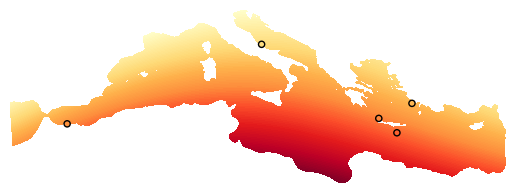

In [10]:
x_test = x0.unsqueeze(0)
u_test = u0.unsqueeze(0)

test_loss = mse(operator(x_test, u_test, x_test), u_test)
print(f"loss/test = {test_loss.item():.4e}")

# Plot with contours
y_plot = vertices.unsqueeze(0)
v_plot = operator(x_test, u_test, y_plot).detach().squeeze()

# Triangulation
tri = Triangulation(vertices[:, 0], vertices[:, 1], mesh.get_cells())
kwargs = {"vmin": v_plot.min(), "vmax": v_plot.max(), "cmap": "YlOrRd"}
cb = plt.tricontourf(tri, v_plot, levels=100, **kwargs)

# Add sensors
plt.scatter(x0[:, 0], x0[:, 1], 20, u0, edgecolors="k", **kwargs)

plt.gca().axis("off")
plt.gca().set_aspect("equal")

For an comprehensive test of the generalization properties, the operator has to
be trained on a larger dataset, but this is beyond the scope of this example
and requires a more elaborated setup.